In [2]:
import torch as t, torch.nn as nn, torch.nn.functional as F, torch.distributions as tdist
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import torchvision as tv, torchvision.transforms as tr
import os
import sys
import numpy as np
#import wideresnet # from The Google Research Authors
import json
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

In [4]:
sigma = 3e-2
#Normalize paramerters are mean, std:  (.49, .48, .44), (.24, .24, .26)
# I found these values were fairly common for the CIFAR10 dataset for some reason
#perhaps they are calculated based on that specific data

transform_normal = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.49, .48, .44), (.24, .24, .26))
         #tr.Normalize((.5, .5, .5), (.5, .5, .5)) #,
         #lambda x: x + sigma * t.randn_like(x)  #keeping the transform basic for now, just normalize the tensors
        ]
    )

# pull the datasets, set download=True on first run
normal_train = tv.datasets.CIFAR10(root='root', transform=transform_normal, download=True, train=True)
normal_test = tv.datasets.CIFAR10(root='root', transform=transform_normal, download=False, train=False)
import torch.utils.data
train_ds, val_ds = random_split(normal_train, [45000, 5000])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting root/cifar-10-python.tar.gz to root
Files already downloaded and verified


In [5]:
# batch size sets how many images are sent to the NN model at one time
batch_size=64
train_ds, val_ds = random_split(normal_train, [45000, 5000])
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [6]:
#from some torch tutorial I can't find right now
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #X is the batch of images, y is the vector of numeric labels for them
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            #print(y)
            #print(pred)
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
# mostly from 
# https://www.analyticsvidhya.com/blog/2021/09/convolutional-neural-network-pytorch-implementation-on-cifar10-dataset/
#baseline working neural net, approximate shape of a "wide res net" with some modifications to experiment with
#Conv2d(in_channels, out_channels, kernel_size, padding) takes a batch of tensors representing an image
# so if your batch size is 64 your input shape is [64, 3, 32, 32] for this example, 64 images, with 3 channels, 
# size 32x32 pixels
#output size is determined by the stride and kernel size
#MaxPool2d(2, 2) has a kernel size of 2x2, and a stride of two, so it looks at each 2x2 grid individually
# and takes the maximum value for the output, then the result size is half the input
class NNThree(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  #input tensors [x, 3, 32, 32]
            nn.Softplus(), #softplus is a different non-linear activation function, similar to ReLU
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  #input [ x, 32, 32, 32]
            nn.Softplus(),  #output [x, 64, 32, 32]
            nn.MaxPool2d(2, 2),  #output [x, 64, 16, 16]
            nn.BatchNorm2d(64), #, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #out [1, 128, 16, 16]
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #out [1, 128, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # out [1, 256, 8, 8]
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # out [1, 256, 8, 8]
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [8]:
# set loss function and optimizer
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = NNThree()
model.to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
#optimizer = t.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=0.0005)

NNThree(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Softplus(beta=1, threshold=20)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Softplus(beta=1, threshold=20)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Max

In [7]:
epochs = 5
for t1 in range(epochs):
    print(f"Epoch {t1+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)
    test(val_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299479 [    0/45000]
loss: 1.431652 [ 6400/45000]
loss: 1.267904 [12800/45000]
loss: 1.147335 [19200/45000]
loss: 0.965200 [25600/45000]
loss: 0.944239 [32000/45000]
loss: 1.070046 [38400/45000]
loss: 0.854743 [44800/45000]
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.322254 

Epoch 2
-------------------------------
loss: 0.911841 [    0/45000]
loss: 1.019013 [ 6400/45000]
loss: 0.767046 [12800/45000]
loss: 1.054867 [19200/45000]
loss: 0.853269 [25600/45000]
loss: 0.749406 [32000/45000]
loss: 0.785524 [38400/45000]
loss: 0.879114 [44800/45000]
Test Error: 
 Accuracy: 61.9%, Avg loss: 1.123281 

Epoch 3
-------------------------------
loss: 0.446158 [    0/45000]
loss: 0.763686 [ 6400/45000]
loss: 0.549196 [12800/45000]
loss: 0.708407 [19200/45000]
loss: 0.793663 [25600/45000]
loss: 0.556533 [32000/45000]
loss: 0.650160 [38400/45000]
loss: 0.634115 [44800/45000]
Test Error: 
 Accuracy: 71.2%, Avg loss: 0.856352 

Epoch 4
--------------------

In [11]:
# trying different stride values per block to see effects.  need to adjust the expected output shape though
# greater stride -> smaller result images, and probably necessary to add padding
class NNFour(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.Softplus(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Softplus(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64), #, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [12]:
# don't run this one
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = NNFour()
model.to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
#optimizer = t.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=0.0005)

NNFour(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Softplus(beta=1, threshold=20)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Softplus(beta=1, threshold=20)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (15): ReLU()
    (16): MaxP

In [13]:
#ignore this
epochs = 5
for t1 in range(epochs):
    print(f"Epoch {t1+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)
    test(val_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


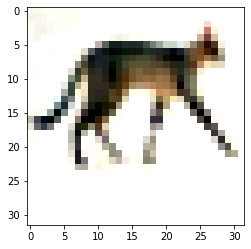

In [10]:
#taken from a pytorch tutorial.  Check out the original image.
#don't go back and shuffle the data between these steps
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

dataiter = iter(train_dl)
images, labels = dataiter.next()
imshow(images[0])


In [11]:
network1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1))
#trying out the Conv2d by itself
(Q, p) = normal_train[0]
Q.to(device)
# get a single image and put it into a tensor of the correct shape of a batch
carrier = t.randn(1, 3, 32, 32)
carrier[0] = images[0]
step1 = network1(carrier)
step1.size()

torch.Size([1, 32, 32, 32])

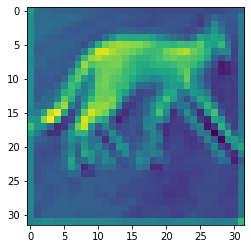

In [12]:
tempimg = step1[0][0].detach()
#tempimg.requires_grad=False
plt.imshow(tempimg)
plt.show()
#show one part of the result of the pass through Conv2d.  There are 32 channels now

In [25]:
images[0].size()

torch.Size([3, 32, 32])

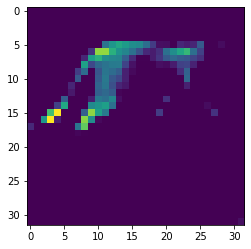

In [14]:
relu = nn.ReLU()
nonlinear = relu(step1)
nonlinear.size()
tempimg3 = nonlinear[0][0].detach()
plt.imshow(tempimg3)
plt.show()

In [18]:
pool = nn.MaxPool2d(2, 2)
#try out the MaxPool2d step alone
pooled = pool(step1)
pooled.size()

torch.Size([1, 32, 16, 16])

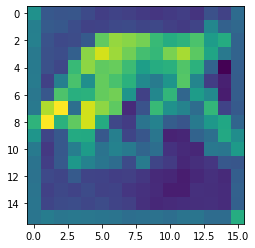

In [20]:
tempimg2 = pooled[0][0].detach()
#tempimg.requires_grad=False
plt.imshow(tempimg2)
plt.show()
#show part of the pooled data.  there are still 32 channels and the images are quarter size now

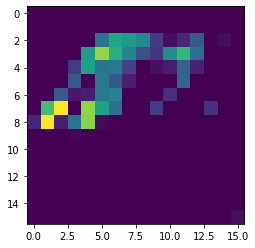

In [16]:
#try one in the right order now instead, i.e. after the ReLU
pool = nn.MaxPool2d(2, 2)
poolednonlinear = pool(nonlinear)
tempimg4 = poolednonlinear[0][0].detach()
plt.imshow(tempimg4)
plt.show()

In [35]:
#save the model
PATH = './manualwideresnetCIFAR10.pth'
t.save(model.state_dict(), PATH)

In [ ]:
# load a saved model back in
model = NNThree()
model.load_state_dict(t.load(PATH))
model.to(device)